## Introduction

In this competition, we are asked  to use reservation and visitation data to predict the total number of visitors to a restaurant for future dates. This information is supposed to help restaurants be much more efficient and allow them to focus on creating an enjoyable dining experience for their customers. 

This is a nice opportunity to learn more about Japan!!!

The data comes from two separate sites:

* Hot Pepper Gourmet (hpg): similar to Yelp, here users can search restaurants and also make a reservation online
* AirREGI / Restaurant Board (air): similar to Square, a reservation control and cash register system

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output
import matplotlib.pyplot as plt
import seaborn as sns
print(check_output(["ls", "../input"]).decode("utf8"))

recruit-restaurant-visitor-forecasting
recruit-restaurant-visitor-forecasting-data



## Data Wrangling

The training data covers the dates from 2016 until April 2017. The test set covers the last week of April and May of 2017. The test set is split based on time (the public fold coming first, the private fold following the public) and covers a chosen subset of the air restaurants. Note that the test set intentionally spans a holiday week in Japan called the "Golden Week."

In [2]:
airres = pd.read_csv('../input/recruit-restaurant-visitor-forecasting/air_reserve.csv')
airstore = pd.read_csv('../input/recruit-restaurant-visitor-forecasting/air_store_info.csv')
hpgres = pd.read_csv('../input/recruit-restaurant-visitor-forecasting/hpg_reserve.csv')
hpgstore = pd.read_csv('../input/recruit-restaurant-visitor-forecasting/hpg_store_info.csv')
airvisit = pd.read_csv('../input/recruit-restaurant-visitor-forecasting/air_visit_data.csv')


In [3]:
airvisit.tail()

,air_store_id,visit_date,visitors
252103,air_24e8414b9b07decb,2017-04-18,6
252104,air_24e8414b9b07decb,2017-04-19,6
252105,air_24e8414b9b07decb,2017-04-20,7
252106,air_24e8414b9b07decb,2017-04-21,8
252107,air_24e8414b9b07decb,2017-04-22,5


In [4]:
airres.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [5]:
air = pd.merge(airres,airstore,on='air_store_id')
hpg = pd.merge(hpgres,hpgstore,on='hpg_store_id')
rel = pd.read_csv('../input/recruit-restaurant-visitor-forecasting/store_id_relation.csv')
airrel = pd.merge(air,rel,how='left',on='air_store_id')
hpgrel = pd.merge(hpg,rel,how='left',on='hpg_store_id')
full = pd.merge(airrel,hpgrel,how='outer')
print("there are ",len(air)," restaurants with AIR and ",len(hpg)," with HPG.",len(rel),' have both.')

there are  92378  restaurants with AIR and  871308  with HPG. 150  have both.


## A Bit of Geography and Clustering

Apparently Japan's terittory is divided in 8 regions which are not official administrative units, but have been traditionally used as the regional division of Japan in a number of contexts [https://en.wikipedia.org/wiki/List_of_regions_of_Japan ]

From north to south, the traditional regions are:
* **Hokkaidō** (the island of Hokkaidō and nearby islands, population: 5,507,456, largest city: Sapporo)
* **Tōhoku** region (northern Honshū, population: 9,335,088, largest city: Sendai)
* **Kantō** region (eastern Honshū, population: 42,607,376, largest city: Tokyo)
* **Chūbu region** (central Honshū, including Mt. Fuji, population: 21,714,995, largest city: Nagoya), sometimes divided into:
   * Hokuriku region (northwestern Chūbu, largest city: Kanazawa)
   * Kōshin'etsu region (northeastern Chūbu, largest city: Niigata)
  * Tōkai region (southern Chūbu, largest city: Nagoya)
* **Kansai or Kinki** region (west-central Honshū, including the old capital, Kyoto, population: 22,755,030, largest city: Osaka)
* **Chūgoku** region (western Honshū, population: 7,561,899, largest city: Hiroshima)
* **Shikoku** (island, population: 3,977,205, largest city: Matsuyama)
* **Kyūshū** (island, population: 14,596,977, largest city: Fukuoka) which includes:
  * Northern Kyushu: Fukuoka, Saga, Nagasaki and Ōita (largest city: Fukuoka)
  * Southern Kyushu: Kumamoto, Miyazaki and Kagoshima (largest city: Kagoshima)
  * Okinawa (largest city: Naha)

![](http://goinjapanesque.com/wpos/wp-content/uploads/2015/07/Japan-map-en.png)

I am now going to identify 10 clusters with KMeans according to the restaurants' coordinates. Markers of different clusters will be depicted with different colors. I will place a black dot representing the cluster centroid with a label identifying it as an integer. I will also place a label close to the cluster with the name of the Japan region in which that cluster relies.

In [6]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(full[['longitude','latitude']])
full['cluster'] = kmeans.predict(full[['longitude','latitude']])

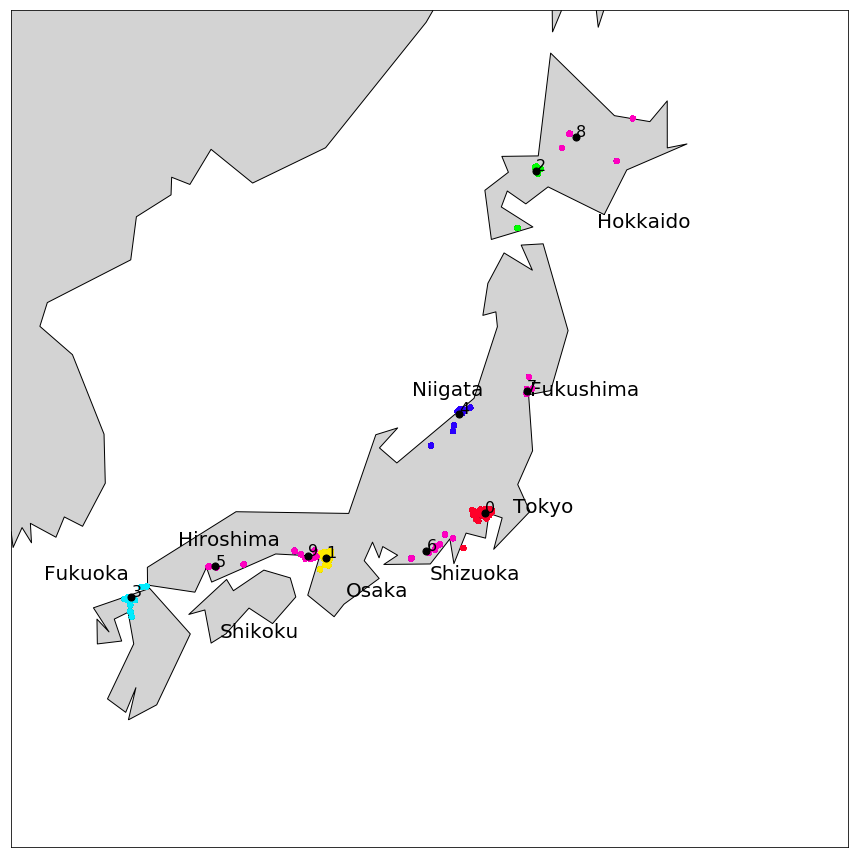

In [7]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
m = Basemap(projection='aeqd',width=2000000,height=2000000, lat_0=37.5, lon_0=138.2)

cx = [c[0] for c in kmeans.cluster_centers_]
cy = [c[1] for c in kmeans.cluster_centers_]
cm = plt.get_cmap('gist_rainbow')
colors = [cm(2.*i/10) for i in range(10)]
colored = [colors[k] for k in full['cluster']]
f,axa = plt.subplots(1,1,figsize=(15,16))
m.drawcoastlines()
m.fillcontinents(color='lightgray',lake_color='aqua',zorder=1)
m.scatter(full.longitude.values,full.latitude.values,color=colored,s=20,alpha=1,zorder=999,latlon=True)
m.scatter(cx,cy,color='Black',s=50,alpha=1,latlon=True,zorder=9999)
plt.setp(axa.get_yticklabels(), visible=True)
plt.annotate('Fukuoka', xy=(0.04, 0.32), xycoords='axes fraction',fontsize=20)
plt.annotate('Shikoku', xy=(0.25, 0.25), xycoords='axes fraction',fontsize=20)
plt.annotate('Hiroshima', xy=(0.2, 0.36), xycoords='axes fraction',fontsize=20)
plt.annotate('Osaka', xy=(0.40, 0.30), xycoords='axes fraction',fontsize=20)

plt.annotate('Tokyo', xy=(0.60, 0.4), xycoords='axes fraction',fontsize=20)
plt.annotate('Shizuoka', xy=(0.50, 0.32), xycoords='axes fraction',fontsize=20)
plt.annotate('Niigata', xy=(0.48, 0.54), xycoords='axes fraction',fontsize=20)
plt.annotate('Fukushima', xy=(0.62, 0.54), xycoords='axes fraction',fontsize=20)
plt.annotate('Hokkaido', xy=(0.7, 0.74), xycoords='axes fraction',fontsize=20)


for i in range(len(cx)):
    xpt,ypt = m(cx[i],cy[i])
    plt.annotate(i, (xpt+500,ypt+500),zorder=99999,fontsize=16)
plt.show()



Let's try to relate the identified groups with the biggest cities:

* Cluster 0 refers to Tokyo.
* Cluster 1 refers  to Osaka
* Cluster 2 refers to Sapporo
* Cluster 3 refers to Fukuoka
* Cluster 4 refers to Niigata
* Cluster 5 referst to Hiroshima
* Cluster 6 refers to Shizouku
* Cluster 7 refers to Sendai
* Cluster 9 refers to Kobe

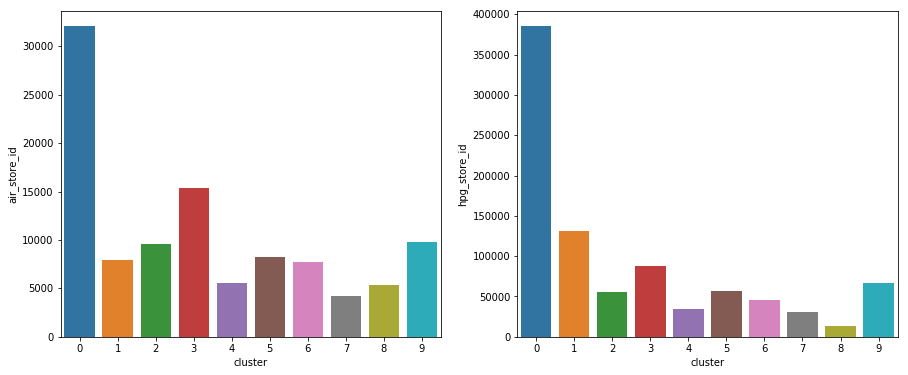

In [8]:
f,axa = plt.subplots(1,2,figsize=(15,6))
hist_clust = full.groupby(['cluster'],as_index=False).count()
sns.barplot(x=hist_clust.cluster,y=hist_clust.air_store_id,ax=axa[0])
sns.barplot(x=hist_clust.cluster,y=hist_clust.hpg_store_id,ax=axa[1])
plt.show()

let's see now how data is distributed

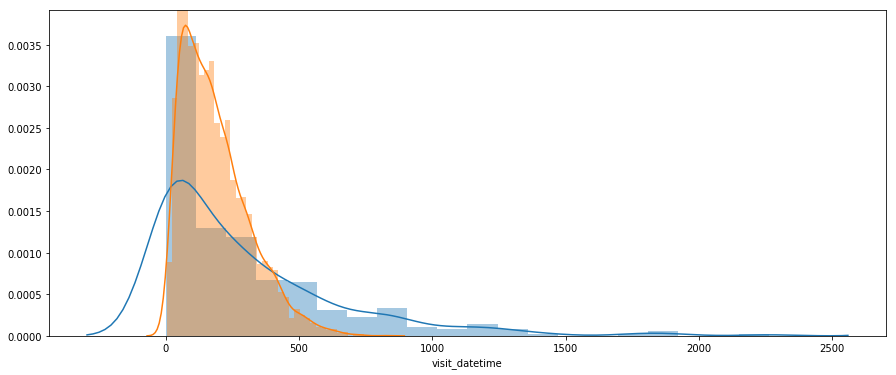

In [9]:
f,ax = plt.subplots(1,1,figsize=(15,6))
airhist = air.groupby(['air_store_id'],as_index=False).count()
sns.distplot(airhist.visit_datetime)
hpghist = hpg.groupby(['hpg_store_id'],as_index=False).count()
sns.distplot(hpghist.visit_datetime)
plt.show()
#sns.barplot(x= airhist.air_store_id,y = airhist.visit_datetime)

## Cousine Genres

Now let's check out wht are the genres appreciated in Japan. I have prepared two heatmaps: the former with thenumber of restaurants for each genre (columns) in each region (row) for thos with AIR reservation  system; the latter with the HPG.

For  the AIR restaurants, It looks like Izakayas, which I learned is a casual place for after-work drinking (like a pub?) https://en.wikipedia.org/wiki/Izakaya,  are the places with the wider appreciation, among regions. 

Italian and French Restaurants are instead the most appreciated in Tokyo, among the restaurants with the AIR system, which makes me happy since I am Italian :).


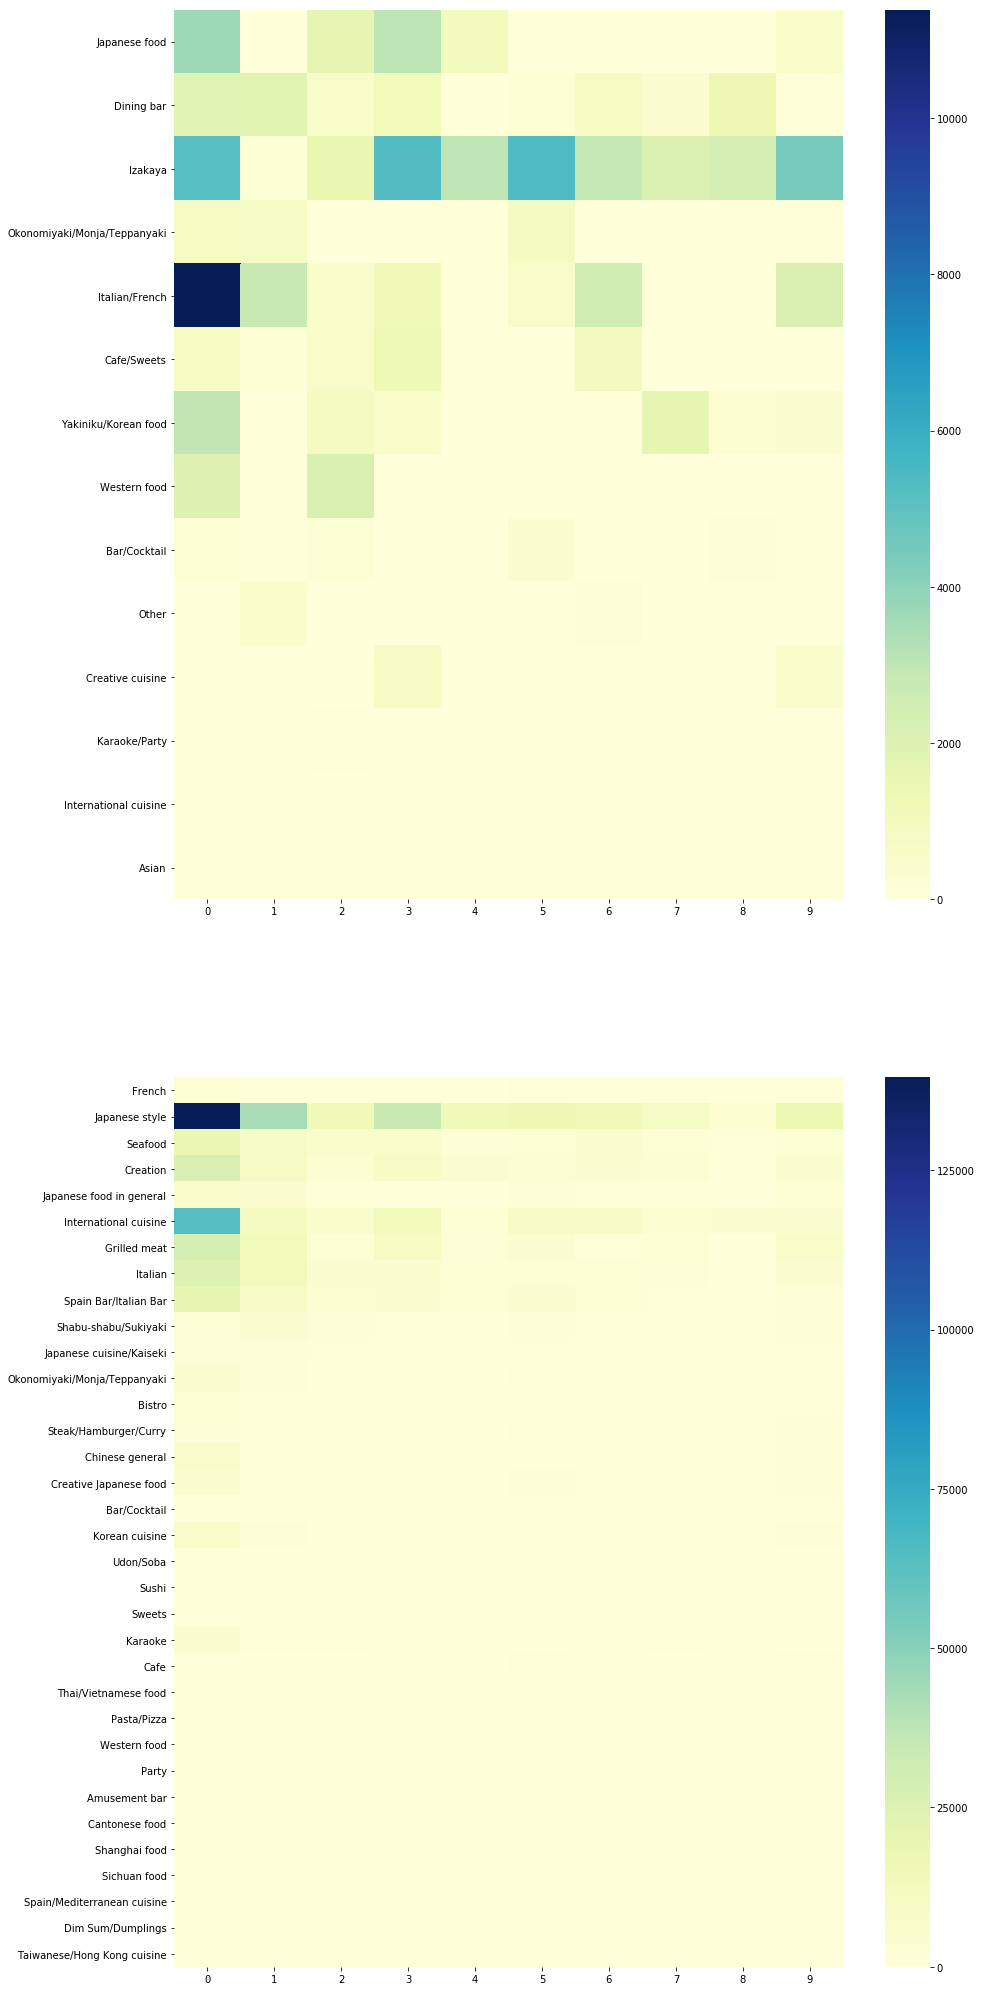

In [10]:
air_genre = full.loc[full.air_genre_name.isnull()==False].groupby(['cluster','air_genre_name'],as_index=False).count()
hpg_genre = full.loc[full.hpg_genre_name.isnull()==False].groupby(['cluster','hpg_genre_name'],as_index=False).count()

genres = air.air_genre_name.unique()

#i = 0
f,axa= plt.subplots(2,1,figsize=(15,36))
hm = []
for i in range(10):
    genres_count = [ air_genre.loc[air_genre.cluster==i].loc[air_genre.air_genre_name==name]['air_store_id'].values[0] if name in air_genre.loc[air_genre.cluster==i].air_genre_name.values else 0 for name in genres] 
    hm.append(genres_count)
hm = pd.DataFrame(hm,columns=genres,)
sns.heatmap(hm.transpose(),cmap="YlGnBu",ax=axa[0])

genres = hpg.hpg_genre_name.unique()
hm = []
for i in range(10):
    genres_count = [ hpg_genre.loc[hpg_genre.cluster==i].loc[hpg_genre.hpg_genre_name==name]['hpg_store_id'].values[0] if name in hpg_genre.loc[hpg_genre.cluster==i].hpg_genre_name.values else 0 for name in genres] 
    hm.append(genres_count)
hm = pd.DataFrame(hm,columns=genres,)
sns.heatmap(hm.transpose(),cmap="YlGnBu",ax=axa[1])


plt.show()

## Japanese Holidays

Let's check what are the Japanese holidays excluding Saturday and Sundays

In [11]:
dates = pd.read_csv('../input/recruit-restaurant-visitor-forecasting/date_info.csv')
dates.loc[dates.holiday_flg==1].loc[(dates.day_of_week !='Saturday')].loc[dates.day_of_week !='Sunday']


,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
10,2016-01-11,Monday,1
41,2016-02-11,Thursday,1
80,2016-03-21,Monday,1
119,2016-04-29,Friday,1
123,2016-05-03,Tuesday,1
124,2016-05-04,Wednesday,1
125,2016-05-05,Thursday,1
199,2016-07-18,Monday,1
223,2016-08-11,Thursday,1


I want to learn more about that so I will rely on this list https://www.officeholidays.com/countries/japan/index.php

* Jan 1st - **New Years day **;
* 2nd Monday of January - **Coming of Age day **: The day honors young Japanese who will reach the age of 20 at any point during the year. Twenty is the age of majority in Japan, and people who have reached this age gain the right to vote in elections as well as to drink;
* Feb 11th - **National Foundation day**:  a national holiday for Japanese people to remind themselves of the nation's founding and foster their love for the nation;
* March 20th or 21st- **Vernal Equinox day**: The day is intended to celebrate the love of nature and living things.In modern Japan, the day still maintains its older traditions as visiting family graves and holding family reunions is a common way of celebrating the equinox;
* April 29th - ** Showa day**: Showa Day honours the birthday of Emperor Hirohito, the reigning Emperor before, during, and after World War II (from 1926 - 1989);

continue...


Now I am going to create two features telling me whther the reservation or the visit occurred in a holiday (reservation_holiday and visit_holiday are the new columns).

In [12]:
vdt = pd.to_datetime(full.visit_datetime)
rdt = pd.to_datetime(full.reserve_datetime)
full['vd']=vdt.dt.date
full['vt']=vdt.dt.time
full['rd']=rdt.dt.date
full['rt']=rdt.dt.time

dts = pd.to_datetime(dates.calendar_date)
days = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
dates['calendar_date'] = pd.to_datetime(dates['calendar_date']).dt.date
dates['dy'] = dts.dt.dayofyear
dates['dw'] = [days.index(dw) for dw in dates.day_of_week]
dates.head()

nf = pd.merge(full,dates[['calendar_date','holiday_flg']],how='left',left_on='vd',right_on='calendar_date')
nf = nf.rename(index = str, columns = {'holiday_flg':'visit_holiday'})
nf = nf.drop(['calendar_date'],axis=1)

nf = pd.merge(nf,dates[['calendar_date','holiday_flg']],how = 'left', left_on='rd',right_on='calendar_date')
nf = nf.rename(index = str, columns = {'holiday_flg':'reservation_holiday'})
nf = nf.drop(['calendar_date'],axis=1)

nf['vd'] = pd.to_datetime(nf['vd']).dt.dayofyear
nf['rd'] = pd.to_datetime(nf['rd']).dt.dayofyear
nf.head()


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,hpg_area_name,cluster,vd,vt,rd,rt,visit_holiday,reservation_holiday
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0,1,19:00:00,1,16:00:00,1,1
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0,1,20:00:00,1,16:00:00,1,1
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0,2,18:00:00,1,16:00:00,1,1
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0,2,21:00:00,1,16:00:00,1,1
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0,8,21:00:00,4,20:00:00,0,0


We can check how many days before the visit japenese people make the reservation.

In [13]:
deltatime = vdt - rdt
days = deltatime.dt.days

days.describe()

count    963686.000000
mean          6.909061
std          11.507296
min           0.000000
25%           1.000000
50%           4.000000
75%           9.000000
max         393.000000
dtype: float64

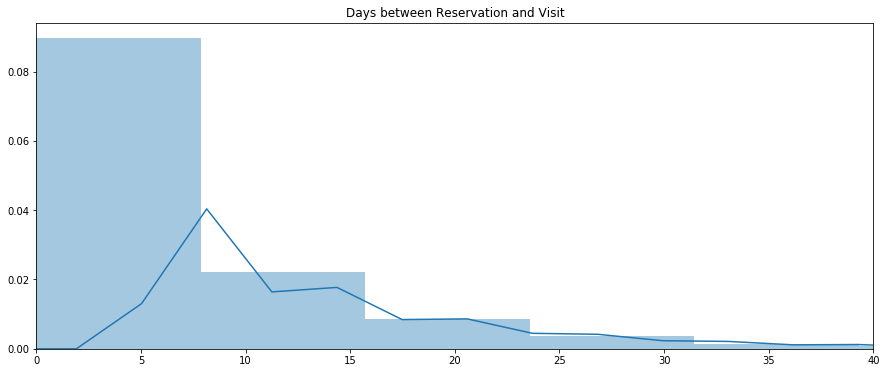

In [14]:
f,axa = plt.subplots(1,1,figsize=(15,6))
sns.distplot(days)
plt.xlim(0,40)
axa.set_title('Days between Reservation and Visit')
plt.show()

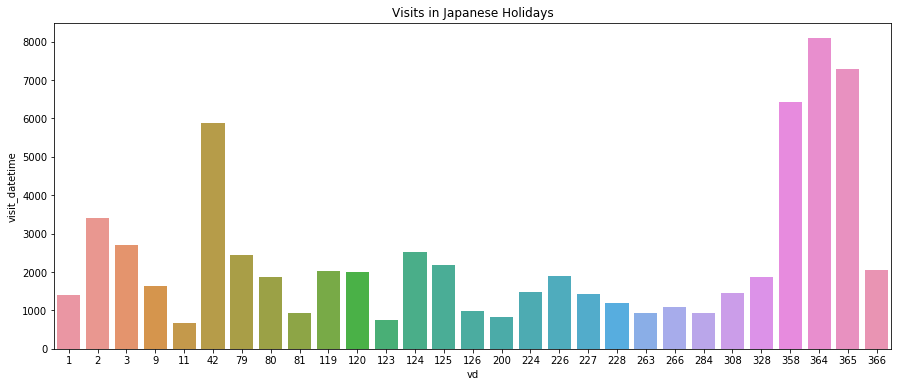

In [15]:
f,ax = plt.subplots(1,1, figsize=(15,6))
vholidayhist= nf[nf['visit_holiday']==1].groupby(['vd'],as_index=False).count()
sns.barplot(x = vholidayhist.vd,y=vholidayhist.visit_datetime)
ax.set_title('Visits in Japanese Holidays')
plt.show()

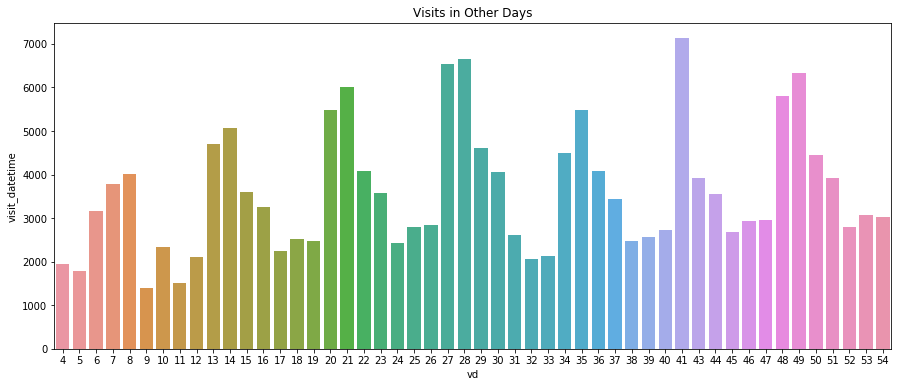

In [16]:
f,ax = plt.subplots(1,1, figsize=(15,6))
vholidayhist= nf[nf['visit_holiday']==0].groupby(['vd'],as_index=False).count()
sns.barplot(x = vholidayhist.vd[0:50],y=vholidayhist.visit_datetime)
ax.set_title('Visits in Other Days')
plt.show()

## Weather Data

In [17]:
wd = pd.read_csv('../input/recruit-restaurant-visitor-forecasting-data/WeatherData.csv')
wd.head()

,area_name,calendar_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature
0,fukuoka_dazaifu-kana_dasaif,1/1/16,0.0,5.7,NaN,NaN,5.1,1.9,NaN,NaN,NaN,NaN,NaN,NaN,11.0,2.1
1,fukuoka_dazaifu-kana_dasaif,1/2/16,0.5,10.2,NaN,NaN,1.3,2.2,NaN,NaN,NaN,NaN,NaN,NaN,15.3,6.1
2,fukuoka_dazaifu-kana_dasaif,1/3/16,0.0,11.2,NaN,NaN,0.5,0.9,NaN,NaN,NaN,NaN,NaN,NaN,15.5,7.1
3,fukuoka_dazaifu-kana_dasaif,1/4/16,0.0,9.4,NaN,NaN,4.2,1.8,NaN,NaN,NaN,NaN,NaN,NaN,16.1,5.9
4,fukuoka_dazaifu-kana_dasaif,1/5/16,1.5,8.8,NaN,NaN,0.0,0.8,NaN,NaN,NaN,NaN,NaN,NaN,12.3,7.1


In [18]:
import re
def area2group(area):
    if re.match(r'tokyo.*',area) !=None:
        return 0
    if re.match(r'osaka.*',area) !=None:
        return 1
    if re.match(r'hokkaido.*',area) !=None:
        return 2    
    if re.match(r'fukuoka.*',area) !=None:
        return 3
    if re.match(r'niigata.*',area) !=None:
        return 4
    if re.match(r'hiroshima.*',area) !=None:
        return 5
    if re.match(r'shizuoka.*',area) !=None:
        return 6
    if re.match(r'miyagi.*',area) !=None:
        return 7
    else:
        return -1

warea = [area2group(area) for area in wd.area_name]
wd['cluster'] = warea
#re.match(r'fukuoka.*',wd.area_name[0])
#wd.area_name

In [19]:
wd['calendar_date'] = pd.to_datetime(wd.calendar_date).dt.date

In [20]:
vdates = pd.to_datetime(nf.visit_datetime).dt.date
nf['visit_date']=vdates

In [21]:
wdg = wd.groupby(['cluster','calendar_date'],as_index=False).mean()
wnf = pd.merge(wdg,nf,left_on=['cluster','calendar_date'],right_on=['cluster','visit_date'])

In [22]:
airvisit['visit_date'] = pd.to_datetime(airvisit['visit_date']).dt.date
wnf = pd.merge(wnf,airvisit,on=['air_store_id','visit_date'])

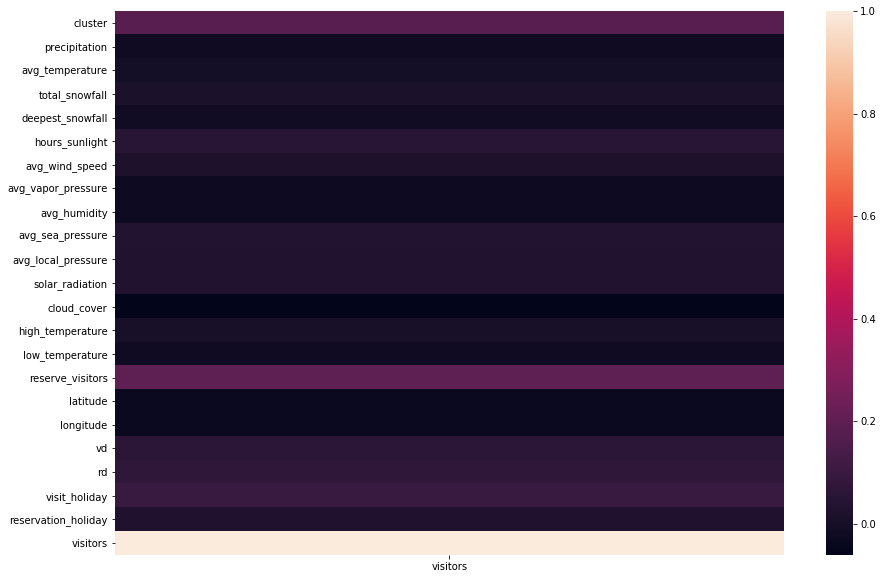

In [23]:
f,axa = plt.subplots(1,1,figsize=(15,10))
sns.heatmap(wnf.corr()[['visitors']])

Apparently there number of visitors is not correlated with the weather conditions